In [9]:
import torch
import argparse

from PIL import Image
from loaders import CxrDataLoader
from torch.utils.data import DataLoader
from pretrained.blip_finetune import BLIPTrainer
from pretrained.blip_datasets import BlipMimicCXRDataset
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoProcessor, AutoModelForImageTextToText

In [2]:
args = argparse.Namespace(
    dataset_name='mimic-cxr',
    batch_size=64,
    num_workers=0,
    max_seq_length=256,
    use_minio=False
)

In [3]:
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

In [5]:
processor = AutoProcessor.from_pretrained("adibvafa/BLIP-MIMIC-CXR")
model = AutoModelForImageTextToText.from_pretrained("adibvafa/BLIP-MIMIC-CXR")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


torch.Size([3, 1024, 1024])


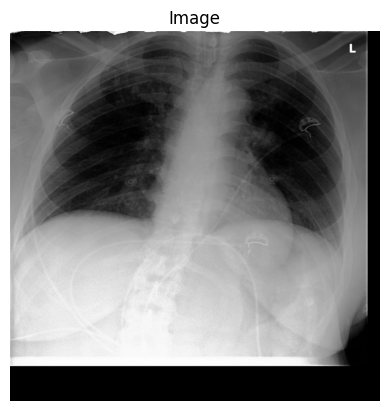

Text: nan AP chest compared to ___:
 
 Tip of the endotracheal tube at the upper margin of the clavicles is no less
 than 45 mm from the carina.  Care should be taken that the tube does not
 withdraw any further.  Lungs are clear.  Cardiomediastinal and hilar
 silhouettes and pleural surfaces are normal.
Generated Report: final report examination : chest ( pa and lat ) indication : _ _ _ year old man with new onset sob / /? pulmonary edema? pulmonary edema impression : in comparison with the study of _ _ _, there is little change in the appearance of the heart and lungs. no evidence of vascular congestion, pleural effusion, or acute focal pneumonia.


In [8]:
test_loader = CxrDataLoader(args, split='test')
sample = next(iter(test_loader))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image = sample['image'][0].to(device)
text = sample['report'][0]
print(image.shape)

pil_img = to_pil_image(image.cpu())

inputs = processor(
    images=image,
    return_tensors="pt"
).to(device)

outputs = model.generate(**inputs, max_length=512)
report = processor.decode(outputs[0], skip_special_tokens=True)

plt.title('Image')
plt.imshow(pil_img)
plt.axis('off')
plt.show()

print('Text:', text)
print('Generated Report:', report)

In [4]:
train_dataset = BlipMimicCXRDataset(args, 'train', processor)
val_dataset = BlipMimicCXRDataset(args, 'val', processor)
test_dataset = BlipMimicCXRDataset(args, 'test', processor)

In [5]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers),
    'val': DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers),
    'test': DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=args.num_workers)
}

In [6]:
trainer = BLIPTrainer(
    model,
    processor,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    test_loader=dataloaders['test'],
    mixed_precision=False,
    log_interval=50,
    max_epochs=1
)

In [ ]:
trainer.train()

2025-04-14 13:31:19,595 - INFO - Starting training
2025-04-14 13:31:19,596 - INFO - Epoch 1
Training:   0%|          | 0/3427 [00:00<?, ?it/s]